In [96]:
import numpy as np #ref
import os
from os import path as op
import string
import re
from subprocess import Popen
import xarray as xr #ref
import metpy #ref
import matplotlib.pyplot as plt #ref
import cartopy.crs as ccrs #ref
import cartopy.feature as cfeature
from pyresample import image, geometry #ref
import seaborn as sns #ref
import netCDF4
sns.set(style="darkgrid")
%matplotlib inline

import logging
import numpy as np
from pyproj import Proj
import pyresample as pr

# Visualizing Images

In [6]:
pathIn = '../../GOES_Files/test_files'
pc = ccrs.PlateCarree()

Green Image (Band 3, recent):

In [36]:
ncFile = 'OR_ABI-L1b-RadC-M6C03_G17_s20210061801177_e20210061803550_c20210061803594.nc'

myFile = xr.open_dataset(op.join(pathIn,ncFile))
dat = myFile.metpy.parse_cf('Rad')
geos = dat.metpy.cartopy_crs

x = dat.x
y = dat.y

data = myFile['Rad'].data
data = np.clip(data, 0, 100)

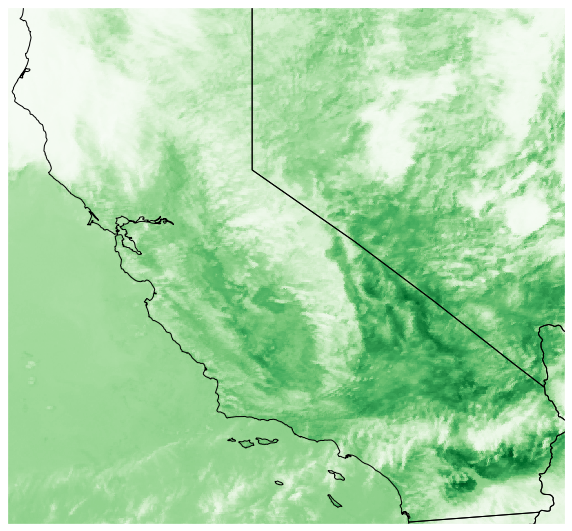

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=pc)

ax.set_extent([-124.50, -114.25, 32.50, 42.00], crs=pc)
#ax.set_extent([-134.40975000,-104.13138889, 52.008563, 22.53472222], crs=pc)

ax.imshow(data, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
           transform=geos,
           interpolation='none',
           cmap = 'Greens')
ax.add_feature(ccrs.cartopy.feature.STATES)

Shortwave Window Image (Band 7, Camp Fire):

In [39]:
ncFile = 'OR_ABI-L1b-RadC-M3C07_G17_s20183261802189_e20183261804573_c20183261805001.nc'

myFile = xr.open_dataset(op.join(pathIn,ncFile))
dat = myFile.metpy.parse_cf('Rad')
geos = dat.metpy.cartopy_crs

x = dat.x
y = dat.y

data = myFile['Rad'].data
data = np.clip(data, 0, 100)

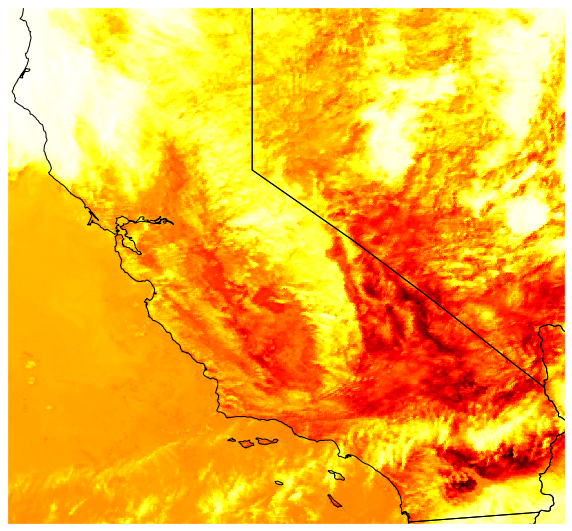

In [41]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=pc)

ax.set_extent([-124.50, -114.25, 32.50, 42.00], crs=pc)
#ax.set_extent([-134.40975000,-104.13138889, 52.008563, 22.53472222], crs=pc)

ax.imshow(data, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
           transform=geos,
           interpolation='none',
           cmap = 'hot_r')
ax.add_feature(ccrs.cartopy.feature.STATES)

# Creating .npys

In [70]:
def create_nc_Numpy(ncFile, pathIn, pathOut):
    myFile = xr.open_dataset(op.join(pathIn,ncFile))
    dat = myFile.metpy.parse_cf('Rad')
    geos = dat.metpy.cartopy_crs

    x = dat.x
    y = dat.y
    
    cartopy_extent_goes = geos.x_limits + geos.y_limits
    goes_params = geos.proj4_params
    rad = dat.data

    def goes_2_roi(loaded_goes, 
               target_extent,
               target_rows,#actual length or base
               target_cols,#actual width or height
               cartopy_target_proj,
               data_key='Rad',
               radius_of_influence=50000):

        #dat = loaded_goes.metpy.parse_cf('Rad')
        geos_crs = dat.metpy.cartopy_crs
        cartopy_source_extent = geos_crs.x_limits + geos_crs.y_limits
        pyresample_source_extent = (cartopy_source_extent[0],
                                    cartopy_source_extent[2],
                                    cartopy_source_extent[1],
                                    cartopy_source_extent[3])
        #rad = dat.data
        source_area = geometry.AreaDefinition('GOES-1X','CONUS','GOES-1X', 
                                              geos_crs.proj4_params,
                                              rad.shape[1], rad.shape[0],
                                              pyresample_source_extent)
        area_target_def = geometry.AreaDefinition('areaTest', 'Target Region', 'areaTest',
                                            cartopy_target_proj.proj4_params,
                                            target_rows, target_cols,
                                            target_extent)
        geos_con_nn = image.ImageContainerNearest(rad, 
                                                source_area, 
                                                radius_of_influence=radius_of_influence)

        area_proj_con_nn = geos_con_nn.resample(area_target_def)
        return area_proj_con_nn.image_data
        
    def cartopy_pyresample_toggle_extent(input_extent):
        return np.array(input_extent)[np.array([0,2,1,3])]

    def trasform_cartopy_extent(source_extent,source_proj, target_proj):
        target_extent = target_proj.transform_points(source_proj, 
                                                     np.array(source_extent[:2]),
                                                     np.array(source_extent[2:])).ravel()
        return cartopy_pyresample_toggle_extent(np.array(target_extent)[np.array([0,1,3,4])])
    
    pc = ccrs.PlateCarree()
    mc = ccrs.Mercator()
    extent_pc = [-134.40975000,-104.13138889, 52.008563, 22.53472222]
    
    target_extent_mc_cartopy = trasform_cartopy_extent(extent_pc, pc, mc)
    target_extent_mc_pyresample = cartopy_pyresample_toggle_extent(target_extent_mc_cartopy)
    
    roi_rads = goes_2_roi(myFile,
               target_extent_mc_pyresample,
               2000, 2000,
               mc)
    roi_rads = np.clip(roi_rads, 0, 100)

    full_filename = op.join(pathOut,ncFile[:-3])
    np.save(full_filename,roi_rads)
    myFile.close()
    return

In [118]:
def create_nc_Numpy(ncFile, pathIn, pathOut):
    myFile = xr.open_dataset(op.join(pathIn,ncFile))
    dat = myFile.metpy.parse_cf('Rad')
    geos = dat.metpy.cartopy_crs

    x = dat.x
    y = dat.y
    
    cartopy_extent_goes = geos.x_limits + geos.y_limits
    goes_params = geos.proj4_params
    rad = dat.data

    def goes_2_roi(loaded_goes, 
               target_extent,
               target_rows,#actual length or base
               target_cols,#actual width or height
               cartopy_target_proj,
               data_key='Rad',
               radius_of_influence=50000):

        #dat = loaded_goes.metpy.parse_cf('Rad')
        geos_crs = dat.metpy.cartopy_crs
        cartopy_source_extent = geos_crs.x_limits + geos_crs.y_limits
        pyresample_source_extent = (cartopy_source_extent[0],
                                    cartopy_source_extent[2],
                                    cartopy_source_extent[1],
                                    cartopy_source_extent[3])
        #rad = dat.data
        source_area = geometry.AreaDefinition('GOES-1X','CONUS','GOES-1X', 
                                              geos_crs.proj4_params,
                                              rad.shape[1], rad.shape[0],
                                              pyresample_source_extent)
        area_target_def = geometry.AreaDefinition('areaTest', 'Target Region', 'areaTest',
                                            cartopy_target_proj.proj4_params,
                                            target_rows, target_cols,
                                            target_extent)
        geos_con_nn = image.ImageContainerNearest(rad, 
                                                source_area, 
                                                radius_of_influence=radius_of_influence)

        area_proj_con_nn = geos_con_nn.resample(area_target_def)
        return area_proj_con_nn.image_data
    
    

    pc = ccrs.PlateCarree()
    mc = ccrs.Mercator()
    extent_pc = [-134.40975000,-104.13138889, 52.008563, 22.53472222]
    
    target_extent = mc.transform_points(pc, 
                                        np.array(extent_pc[:2]),
                                        np.array(extent_pc[2:])).ravel()
    target_extent_mc_cartopy = np.array(np.array(target_extent)[np.array([0,1,3,4])])[np.array([0,2,1,3])]
    target_extent_mc_pyresample = np.array(target_extent_mc_cartopy)[np.array([0,2,1,3])]
    
    roi_rads = goes_2_roi(myFile,
               target_extent_mc_pyresample,
               2000, 2000,
               mc)
    roi_rads = np.clip(roi_rads, 0, 100)

    full_filename = op.join(pathOut,ncFile[:-3])
    np.save(full_filename,roi_rads)
    myFile.close()
    return

Green Array (Band 1, recent):

In [119]:
create_nc_Numpy('OR_ABI-L1b-RadC-M6C03_G17_s20210061801177_e20210061803550_c20210061803594.nc', '../../GOES_Files/test_files', '../../GOES_Files/test_files')

/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(
/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(


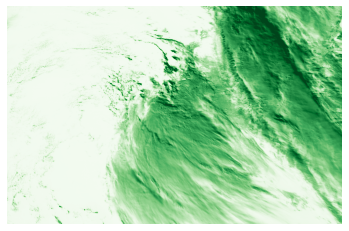

In [120]:
img_array = np.load("../../GOES_Files/test_files/OR_ABI-L1b-RadC-M6C03_G17_s20210061801177_e20210061803550_c20210061803594.npy")
plt.imshow(img_array, aspect='auto', cmap='Greens')
plt.axis('off')
plt.show()

Shortwave Window Array (Band 7, Camp Fire):

In [147]:
create_nc_Numpy('OR_ABI-L1b-RadC-M3C07_G17_s20183261802189_e20183261804573_c20183261805001.nc', '../../GOES_Files/test_files', '../../GOES_Files/test_files')

/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(
/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyresample/image.py:60: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(


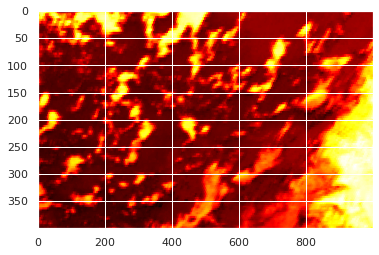

In [3]:
img_array = np.load("../../GOES_Files/test_files/OR_ABI-L1b-RadC-M3C07_G17_s20183261802189_e20183261804573_c20183261805001.npy")
plt.imshow(img_array, aspect='auto', cmap='hot_r')
plt.show()